In [1]:
import sys
sys.path.insert(1, './env')
sys.path.insert(1, './agents')

import gym
import pylab
import random
import strategy_imitation, sarsa, ddqn, random_agent, a2c, model_based
import aa_gun,jet_table
import numpy as np
from collections import deque
import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [2]:
#массовый тест моделей

_____ 2020-04-07 20:33:09.386104




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0

Epoch 1/2
102/102 [==============================] - 0s 52us/step - loss: 4.0205
Epoch 2/2
102/102 [==============================] - 0s 48us/step - loss: 5.0553
Epoch 1/2
102/102 [==============================] - 0s 44us/step - loss: 4.0891
Epoch 2/2
102/102 [==============================] - 0s 49us/step - loss: 3.8559
Epoch 1/2
102/102 [==============================] - 0s 57us/step - loss: 4.2486
Epoch 2/2
102/102 [==============================] - 0s 63us/step - loss: 3.7182
Epoch 1/2
102/102 [==============================] - 0s 58us/step - loss: 3.0736
Epoch 2/2
102/102 [==============================] - 0s 70us/step - loss: 3.7453
Epoch 1/2
102/102 [==============================] - 0s 43us/step - loss: 2.7115
Epoch 2/2
102/102 [==============================] - 0s 44us/step - loss: 3.4557
Epoch 1/2
102/102 [==============================] - 0s 46us/step - loss: 2.8731
Epoch 2/2
102/102 [==============================] - 0s 49us/step - loss: 2.8689
Epoch 1/2
102/102 [=========

KeyboardInterrupt: 

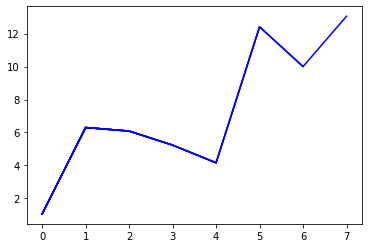

In [3]:
#Проверь на зенитке, на cartpole и на mountain car
EPISODES=1400

print('_____',pd.Timestamp.now())
#здесь весь код от инициализации модели до выдачи scores.
# In case of CartPole-v1, maximum length of episode is 500

env = jet_table.jet_table_env()
#env = gym.make('Seaquest-ramNoFrameskip-v0')
#env=CartPoleEnv9()
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = sarsa.SarsaAgent(state_size, action_size)
agent.train_start=100
#agent.train_start=7000
#agent.epsilon_decay=0.9999
agent.render=True

scores, episodes = [], []
reward_lst = []
s_list=[]
a_list=[]

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    

    while not done:
        if (e in range(0,3)) or (e in range(20,22)) or (e in range(30,32)) or (e in range(40,42)) or (e in range(50,52)) or (e in range(100,103)) or (e in range(200,202)) or (e in range(300,306)) or (e in range(400,406)) or (e in range(500,506)) or (e in range(600,604)):
            if agent.render:
                env.render()

        # get action for the current state and go one step in environment
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100


        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        #if next_state[0,11]!=reward:
        #    print('state[13]!=reward',state[0,11],reward)
        #
        s_list.append(state)
        a_list.append(action)
        reward_lst.append(reward)
        #

        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            #pylab.savefig("./save_graph/aa_gun_dqn.png")
            try:
                print("episode:", e, "  score:", score,np.mean(scores), "  memory length:",
                      len(agent.s), "  epsilon:", agent.epsilon)
            except Exception:
                print("episode:", e, "  score:", score,np.mean(scores), "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
